In [139]:
import numpy as np
import pickle
import os
from sklearn.utils import shuffle
import sys
import librosa
import IPython.display
from python_speech_features import mfcc
from python_speech_features import delta

In [140]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout
import keras.optimizers
from keras.models import load_model
import keras.regularizers
from keras.regularizers import l2, l1

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
t_root = "/data/corpora/switchboard-1/swb_ms98_transcriptions/"
a_root = "/data/corpora/switchboard-1/97S62/" 

In [143]:
def compute_mfcc_features(y,sr):
    return mfcc(y,samplerate=sr,winlen=0.025,winstep=0.01)

def compute_delta_features(mfcc_feat):
    return delta(mfcc_feat, 2)

In [144]:
def get_train_val_test_folders(t_root):
    t_folders = [t_root + f for f in os.listdir(t_root) if os.path.isdir(t_root + f)]
    t_folders.sort()
    train_folders = t_folders[0:20]
    val_folders = t_folders[20:25]
    test_folders = t_folders[25:30]
    train_folders.sort(); val_folders.sort(); test_folders.sort()
    return (train_folders, val_folders, test_folders)

def get_transcriptions_files(folder):
    files = []
    subfolders = [folder + "/" + f for f in os.listdir(folder)]
    for f in subfolders:
        fs = [f + "/" + fname for fname in os.listdir(f) if 'a-word.text' in fname and 'A' in fname]
        files += fs
    files.sort()
    return files

def get_all_transcriptions_files(folder_list):
    files = []
    for folder in folder_list:
        files += get_transcriptions_files(folder)
    files.sort()
    return files

def get_transcription_files_with_laughter_in_corpus(folder_list):
    files = []
    transcription_files = get_all_transcriptions_files(folder_list)
    for f in transcription_files:
        if count_laughter_instances_in_transcription_file(f) > 0:
            files.append(f)
    return files

def count_transcription_files_with_laughter_in_corpus(folder_list):
    return len(get_transcription_files_with_laughter_in_corpus(folder_list))

In [145]:
def get_sph_files(folder):
    return [folder + "/" + f for f in os.listdir(folder) if ".sph" in f]

def get_all_audio_files(a_root):
    files = []
    a_folders = [a_root + f + "/data" for f in os.listdir(a_root) if os.path.isdir(a_root + f)]
    a_folders.sort()
    for folder in a_folders:
        files += get_sph_files(folder)
    files.sort()
    return files

In [146]:
def get_text_from_file(f):
    return (open(f).read().split("\n"))[0:-1]

def get_laughter_rows_from_file(f):
    #return [l for l in get_text_from_file(f) if '[laughter]' in l]
    return [l for l in get_text_from_file(f) if 'laughter' in l] # allows laughter with words together

def get_audio_file_from_id(d):
    files = [f for f in all_audio_files if d in f]
    if len(files) == 1:
        return files[0]
    elif len(files) > 1:
        print "More than 1 audio file matched id %d" % (int(d))
        return None
    else:
        print "No audio file matched id %d" % (int(d))
        return None
        
def get_id_from_row(row):
    return row[2:6]

def get_id_from_file(f):
    return get_id_from_row(get_text_from_file(f)[0])

def get_audio_file_from_row(row):
    return get_audio_file_from_id(get_id_from_row(row))

def get_audio_file_from_transcription_text(t):
    return get_audio_file_from_id(get_id_from_row(t[0]))

def get_audio_file_from_transcription_file(f):
    t = open(f).read().split('\n')
    return get_audio_file_from_id(get_id_from_row(t[0]))

def get_audio_file_length(path):
    f = audioread.audio_open(path)
    l = f.duration
    f.close()
    return l

In [147]:
def count_laughter_instances_in_transcription_file(f):
    rows = get_laughter_rows_from_file(f)
    return len(rows)

def count_laughter_instances_in_corpus(folder_list):
    transcription_files = get_all_transcriptions_files(folder_list)
    count = 0
    for f in transcription_files:
        count += count_laughter_instances_in_transcription_file(f)
    return count

In [148]:
def get_audio_files_from_transcription_files(transcription_files):
    files = []
    for f in transcription_files:
        files.append(get_audio_file_from_transcription_file(f))
    files = list(set(files))
    files.sort()
    if None in files: files.remove(None)
    return files

In [149]:
all_audio_files = get_all_audio_files(a_root)
train_folders, val_folders, test_folders = get_train_val_test_folders(t_root)

In [150]:
print "Laughter instances in training data: %d" % (count_laughter_instances_in_corpus(train_folders))
print "Laughter instances in validation data: %d" % (count_laughter_instances_in_corpus(val_folders))
print "Laughter instances in test data: %d" % ( count_laughter_instances_in_corpus(test_folders))
print
print "Files containing laughter in training data: %d" % (count_transcription_files_with_laughter_in_corpus(train_folders))
print "Files containing laughter in validation data: %d" % (count_transcription_files_with_laughter_in_corpus(val_folders))
print "Files containing laughter in test data: %d" % (count_transcription_files_with_laughter_in_corpus(test_folders))

Laughter instances in training data: 14760
Laughter instances in validation data: 2056
Laughter instances in test data: 1004

Files containing laughter in training data: 1706
Files containing laughter in validation data: 346
Files containing laughter in test data: 155


In [151]:
train_transcription_files = get_transcription_files_with_laughter_in_corpus(train_folders)
val_transcription_files = get_transcription_files_with_laughter_in_corpus(val_folders)
test_transcription_files = get_transcription_files_with_laughter_in_corpus(test_folders)

In [152]:
train_audio_files = get_audio_files_from_transcription_files(train_transcription_files)
val_audio_files = get_audio_files_from_transcription_files(val_transcription_files)
test_audio_files = get_audio_files_from_transcription_files(test_transcription_files)
print len(train_audio_files)
print len(val_audio_files) 
print len(test_audio_files)

No audio file matched id 2289
No audio file matched id 4361
No audio file matched id 4379
1705
344
155


In [153]:
t_file = test_transcription_files[89]

In [154]:
get_laughter_rows_from_file(t_file)

['sw4774A-ms98-a-0001 1.920000 2.460000 [laughter-topic]',
 'sw4774A-ms98-a-0003 6.232375 8.719875 [laughter]']

In [155]:
def frame_to_time(frame_index):
    return(frame/100.)

In [156]:
a_file = get_audio_file_from_transcription_file(t_file)

In [157]:
a_file

'/data/corpora/switchboard-1/97S62/swb1_d4/data/sw04774.sph'

In [158]:
#a_file = 'baby_laugh.wav'

In [159]:
model = load_model('ff_model3.h5')

In [160]:
y,sr = librosa.load(a_file,sr=8000)

In [161]:
len(y) / sr

299

In [162]:
mfcc_feat = compute_mfcc_features(y,sr)
delta_feat = compute_delta_features(mfcc_feat)

In [163]:
mfcc_feat.shape

(29954, 13)

In [164]:
window_size = 37

In [165]:
mfcc_feat.shape

(29954, 13)

In [167]:
zero_pad = np.zeros((window_size,mfcc_feat.shape[1]))
zero_pad.shape

(37, 13)

In [168]:
padded_mfcc_feat = np.vstack([zero_pad,mfcc_feat,zero_pad])
padded_delta_feat = np.vstack([zero_pad,delta_feat,zero_pad])

In [169]:
def format_features(mfcc_feat, delta_feat,index):
    return np.append(mfcc_feat[index-window_size:index+window_size],delta_feat[index-window_size:index+window_size])

In [170]:
feature_list = []
for i in range(window_size, len(mfcc_feat) + window_size):
    feature_list.append(format_features(padded_mfcc_feat, padded_delta_feat, i))

In [171]:
feature_list = np.array(feature_list)

In [172]:
feature_list.shape

(29954, 1924)

In [173]:
mfcc_feat.shape

(29954, 13)

In [174]:
probs = model.predict_proba(feature_list).reshape((len(mfcc_feat),))

29920/29954 [============================>.] - ETA: 0s

In [175]:
probs.shape
#probs = np.vstack([np.zeros((37,1)),probs,np.zeros((37,1))]).reshape((len(mfcc_feat),))

(29954,)

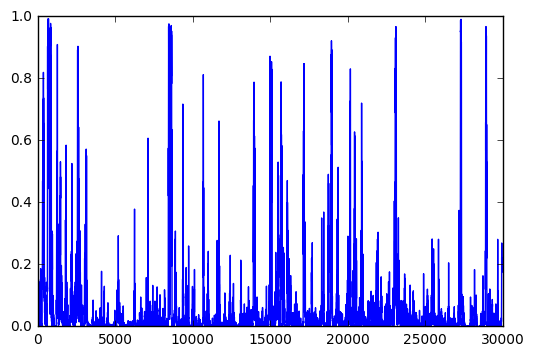

In [176]:
plt.plot(xrange(len(probs)),probs)

In [177]:
import scipy.signal as signal
 
#Butterworth filter
N  = 2    # Filter order
Wn = 0.01 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
filtered = signal.filtfilt(B,A, probs)

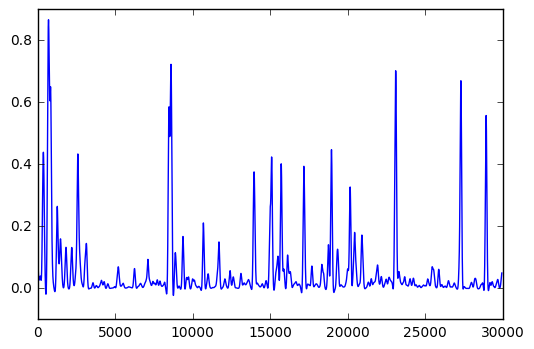

In [178]:
plt.plot(xrange(len(filtered)),filtered)

In [179]:
probs_avg = []
for i in xrange(len(probs)):
    if i < window_size or i > len(probs) - window_size:
        m = 0
    else:
        m = np.mean(probs[i-10:i+10])
    probs_avg.append(m)

In [180]:
def collapse_to_start_and_end_frame(instance_list):
    return (instance_list[0], instance_list[-1])

def frame_span_to_time_span(frame_span):
    return (frame_span[0] / 100., frame_span[1] / 100.)

def seconds_to_samples(s,sr):
    return s*sr

In [185]:
instances = []
current_list = []
for i in xrange(len(filtered)):
    if np.min(filtered[i:i+1]) > 0.5:
        current_list.append(i)
    else:
        if len(current_list) > 0:
            instances.append(current_list)
            current_list = []

instances = [frame_span_to_time_span(collapse_to_start_and_end_frame(i)) for i in instances if len(i) > 20]

In [186]:
instances

[(6.43, 8.78),
 (84.52, 85.2),
 (85.43, 86.55),
 (230.61, 231.47),
 (272.75, 273.47),
 (289.18, 289.6)]

In [187]:
get_laughter_rows_from_file(t_file)

['sw4774A-ms98-a-0001 1.920000 2.460000 [laughter-topic]',
 'sw4774A-ms98-a-0003 6.232375 8.719875 [laughter]']

In [188]:
def cut_laughter_segments(instance_list,y,sr):
    new_audio = []
    for start, end in instance_list:
        sample_start = int(seconds_to_samples(start,sr))
        sample_end = int(seconds_to_samples(end,sr))
        clip = y[sample_start:sample_end]
        new_audio = np.concatenate([new_audio,clip])
    return new_audio

def get_instances_from_rows(rows):
    return [(float(row.split(' ')[1]),float(row.split(' ')[2])) for row in rows]

In [189]:
auto_laughs = cut_laughter_segments(instances,y,sr)

In [194]:
IPython.display.Audio(auto_laughs,rate=sr)

In [49]:
annotated_laughs = cut_laughter_segments(get_instances_from_rows(get_laughter_rows_from_file(t_file)),y,sr)

In [50]:
IPython.display.Audio(annotated_laughs,rate=sr)

In [193]:
IPython.display.Audio('laughs.wav')

In [198]:
librosa.output.write_wav('laughs.wav',auto_laughs,sr)

In [196]:
auto_laughs.shape

(49200,)